# E-tivity 1 (Weeks 1-2)

* Barry Clarke

* 24325082

## Anomaly Detection

### Context
We have a mystery dataset. There are 9 explanatory variables and one response variable. The response variable is the last column and indicates if the sample is anomalous (=1, valid =0). The dataset is provided "data.csv".

Of course in this case we could use supervised learning to generate a model and detect anomalies in new data. However the focus is on autoencoders, anomaly detection is just one of the potential uses for autoencoders.

So we are going to pretend that we do not know which data are anomalous but we do know that the anomaly rate is small. Use an autoencoder to detect anomalies in the data. The correctness of the model can of course be checked.

### Guidelines

The e-tivity is split into four tasks. The first three are "group" excersises, in that you post the solutions to Tasks 1-3 to a site. This will allow the members of your group to send you feedback (via the forums) so you can improve your submission. The final task is an individual task and together with the other tasks, should be uploaded to the Group Locker.

Marks will be deducted if task 4 is uploaded in contravention of instructions. Also if the the final submission is not a single notebook with tasks 1-4 and with correct identification or filename.

Grading guidelines: the scores for each task are additive. Below is a link to the E-tivity rubrics.

https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=73310&rubricId=4445&originTool=quicklinks



## Problem

If you train even a modest feed forward network via supervised learning you can get extremely good recall and precision, despite the unbalanced dataset. However in this e-tivity you will determining the anomalies by using an autoencoder. That is you will **not** be using the Anom flag to guide the training.

The mystery dataset is available from Brightspace, download the csv file and use it as the input data.

### Tasks 1-3 (complete by Sunday Week 2)

Create additional cells to implement the tasks below. These task form the group learning section of the E-tivity. As such it is encouraged that you post yuor notebook in the group locker.

Grading guidelines are given in the rubrics for the E-tivity

https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=73310&rubricId=4445&originTool=quicklinks

### Task 4: VAE (completed by Sunday Week 2)

This task is a individual task and should **not** to be uploaded to the Group Locker. No direct support should be given via the forums. Marks will be deducted if the instructions are not followed (see rubrics). This part should be uploaded directly to Brightpsace.

Change the network to be a VAE. Again determine the optimal cutoff and plot the latent variables. Check how good the cutoffs were by constructing a confusion matrix or generating a classification report. Obviously for this task you need to use the Anom column.

**Hint** you can use the model topology from the AE (with the obvious modifications). I found that I had a good model (almost as good and the supervised learning model) when the KL divergence was small. You can print out both the KL divergence and reconstruction loss for each epoch. It can be tricky to train these type of models, so do not be surprised if you do not get a stellar result. What is more important is that you have the correct code to implement the VAE.

### Final Submission (complete by Sunday Week 2)

Submit Tasks 1-4 in a single notebook this before the deadline on Sunday.


Starting Training...
Training Complete.
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


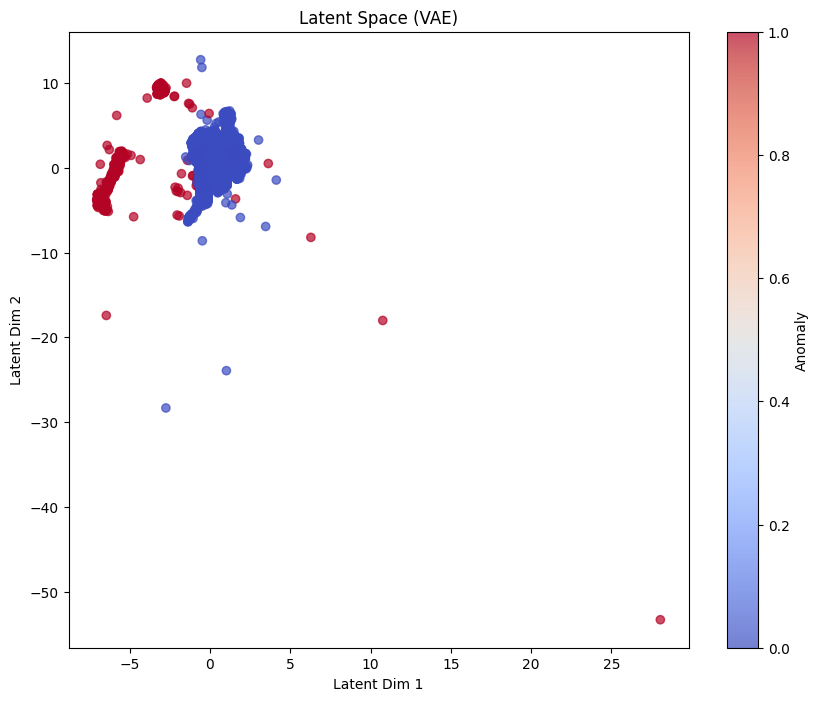

307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
VAE Reconstruction Threshold: 29.8005

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      9100
           1       0.50      0.01      0.01       720

    accuracy                           0.93      9820
   macro avg       0.71      0.50      0.49      9820
weighted avg       0.90      0.93      0.89      9820

Confusion Matrix:


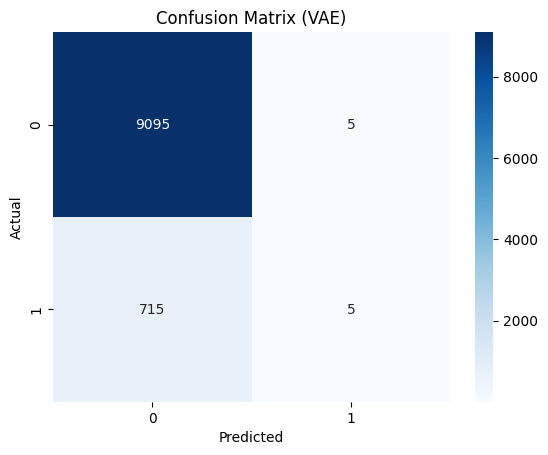

In [7]:
# ==========================================
# Task 4: Variational Autoencoder (VAE)
# ==========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, backend as K
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# ---------------------------------------------------------
# PART 1: PREP WORK
# ---------------------------------------------------------

# 1. Load Data
try:
    df = pd.read_csv('data.csv')
except FileNotFoundError:
    print("Error: 'data.csv' not found. Please upload it.")
    raise

# 2. Prep Data
# Similar to Task 1 and 'REF_DimRedComparison', features (X) and target (y) are separated.
# The target 'y' is needed here for the final classification report required by the task.
X = df.drop('Anom', axis=1)
y = df['Anom']

# Standard 80/20 split used again.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling is crucial for VAEs to ensure the loss function (MSE) works correctly.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
input_dim = X_train_scaled.shape[1]

# ---------------------------------------------------------
# PART 2: DEFINE LAYERS
# ---------------------------------------------------------

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z."""

    # This custom layer implements the 'reparameterisation trick' discussed in VAE theory.
    # It allows the model to learn parameters (mean and variance) whilst still supporting backpropagation.
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

class VAELossLayer(layers.Layer):
    """Calculates VAE loss and adds it to the model internally."""
    def call(self, inputs):
        x_true, x_pred, z_mean, z_log_var = inputs

        # 1. Reconstruction Loss (MSE)
        # Calculates how well the output matches the input.
        # Scaled by 1000 to balance with the KL loss, a common trick for stability.
        rec_loss = tf.reduce_mean(tf.square(x_true - x_pred), axis=1) * 1000

        # 2. KL Divergence Loss
        # Regularises the latent space to keep it close to a normal distribution.
        # This math matches the standard VAE loss formula seen in similar implementations.
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)

        # The total loss is added directly to the layer (Updated for Keras 3 compatibility).
        self.add_loss(tf.reduce_mean(rec_loss + kl_loss))

        # Returns the reconstruction so the model has a valid output.
        return x_pred

# ---------------------------------------------------------
# PART 3: BUILD MODEL
# ---------------------------------------------------------

# The task requires plotting latent variables, so 2 dimensions are chosen for easy visualisation.
latent_dim = 2

# --- ENCODER ---
# Topology is modified from the AE in Task 2 (using Dense layers), as suggested by the instructions.
vae_input = layers.Input(shape=(input_dim,), name="vae_input")
x = layers.Dense(7, activation='relu')(vae_input)

# Instead of one bottleneck, the encoder outputs Mean and Log Variance vectors.
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# The sampling layer generates the latent vector 'z'.
z = Sampling()([z_mean, z_log_var])

# --- DECODER ---
# The decoder mirrors the encoder to reconstruct the input.
decoder_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(7, activation='relu')(decoder_input)
decoder_output = layers.Dense(input_dim, activation='linear')(x)
decoder_model = Model(decoder_input, decoder_output, name="decoder")

reconstruction = decoder_model(z)

# --- LOSS HANDLING ---
# The custom layer handles the complex VAE loss calculation (Reconstruction + KL).
final_output = VAELossLayer()([vae_input, reconstruction, z_mean, z_log_var])

# --- ASSEMBLE ---
# The model maps Input -> Final Output (Reconstruction).
vae = Model(inputs=vae_input, outputs=final_output)
vae.compile(optimizer='adam')

# ---------------------------------------------------------
# PART 4: TRAIN
# ---------------------------------------------------------

print("Starting Training...")
# Training on X -> X (unsupervised).
# Note: y is set to None because the custom layer calculates loss internally.
history = vae.fit(X_train_scaled, None,
                  epochs=50,
                  batch_size=32,
                  shuffle=True,
                  verbose=0)
print("Training Complete.")

# ---------------------------------------------------------
# PART 5: VISUALISE & DETECT
# ---------------------------------------------------------

# --- A. Latent Space ---
# To visualise the "manifold", a separate model predicts the z_mean.
encoder_model = Model(vae_input, z_mean)
z_test_latent = encoder_model.predict(X_test_scaled)

plt.figure(figsize=(10, 8))
# Scatter plot coloured by 'y_test' to see if anomalies cluster differently.
scatter = plt.scatter(z_test_latent[:, 0], z_test_latent[:, 1], c=y_test, cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, label='Anomaly')
plt.title("Latent Space (VAE)")
plt.xlabel("Latent Dim 1")
plt.ylabel("Latent Dim 2")
plt.show()

# --- B. Detect Anomalies ---
# Reconstructions are generated for the test set.
reconstructions_vae = vae.predict(X_test_scaled)

# Reconstruction error (MSE) is calculated per sample.
mse_vae = np.mean(np.power(X_test_scaled - reconstructions_vae, 2), axis=1)

# Threshold is set using Mean + 2 Standard Deviations.
# This is a common statistical cutoff for outlier detection.
threshold_vae = np.mean(mse_vae) + 2 * np.std(mse_vae)
print(f"VAE Reconstruction Threshold: {threshold_vae:.4f}")

# Predictions: 1 if error > threshold, else 0.
y_pred_vae = [1 if e > threshold_vae else 0 for e in mse_vae]

# Report
# Generating the classification report and confusion matrix as requested in Task 4 instructions.
print("\nClassification Report:")
print(classification_report(y_test, y_pred_vae))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_vae)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (VAE)')
plt.show()

## Reflection

There are no specific marks allocated for a reflection. However due consideration will be given if pertinent comments or valuable insights are made.